In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns;
sns.set()

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

from ipywidgets import interact 

#Modelo
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix, classification_report

In [2]:
def show_results(y, y_pred):
    sns.heatmap(confusion_matrix(y, y_pred), square=True, annot=True, fmt='d', cbar=True, cmap=plt.cm.Blues)
    plt.ylabel('Clase real')
    plt.xlabel('Predicción');
    plt.gca().set_ylim(2.0, 0)
    plt.show()
    print("Resultados")
    print('Accuracy: {}'.format(round(accuracy_score(y, y_pred), 3)))

In [3]:
df = pd.read_csv('./data/Modelar_UH2020.txt', index_col='ID', delimiter='|', encoding='utf-8')

In [4]:
df.shape

(103230, 55)

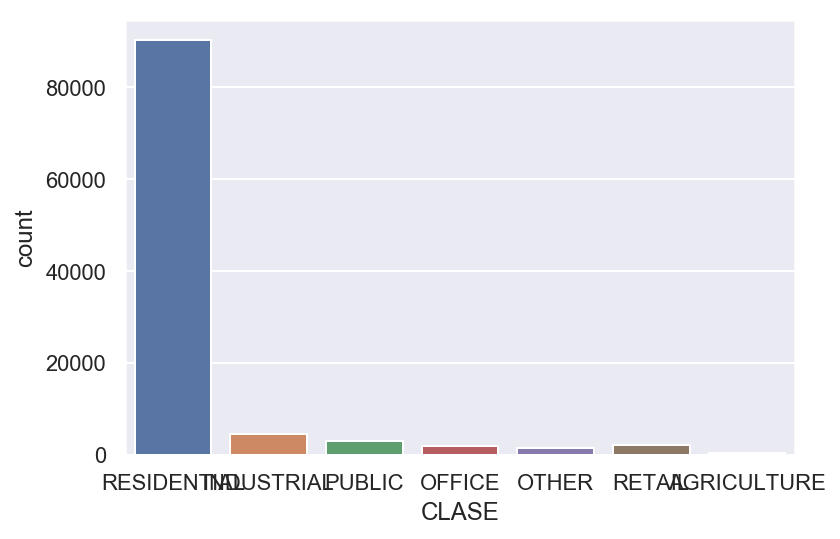

In [5]:
sns.countplot(df.CLASE)

In [6]:
df.CLASE.value_counts()

RESIDENTIAL    90173
INDUSTRIAL      4490
PUBLIC          2976
RETAIL          2093
OFFICE          1828
OTHER           1332
AGRICULTURE      338
Name: CLASE, dtype: int64

In [6]:
def process_cadastral_quality(df):
    dic = {'A': 11, 'B': 10, 'C': 9, '1': 8, '2': 7, '3': 6, '4': 5, '5': 4, '6': 3, '7': 3, '8': 1, '9': 0}
    if (df['CADASTRALQUALITYID'].dtype != int):
        df['CADASTRALQUALITYID'] = df['CADASTRALQUALITYID'].apply(lambda x: dic[x] if x not in [np.NaN] else -1)

def process_max_building_floor(df):
    df['MAXBUILDINGFLOOR'].fillna(-1, inplace=True) 
    
def assing_subclass(df):
    df['SUBCLASE'] = (df['CLASE'] == 'RESIDENTIAL').astype(int)
    
process_cadastral_quality(df)
process_max_building_floor(df)
assing_subclass(df)

In [7]:
X = df.drop(columns=df.columns[-2:]).copy()
y = df['SUBCLASE'].copy()

#Obtenemos las columnas nunéricas
number_df_columns = df.select_dtypes(include=np.number).columns.tolist()
number_df_columns.remove('SUBCLASE')

#Transformación que se le va a aplicar a las columnas numéricas
num_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
                             ('scaler', StandardScaler())])
#Transformador que se aplica a cada una de las columnas en función a lo declarado previamente
df_minsait_trans = ColumnTransformer(transformers=[('num', num_transformer, number_df_columns)])
sm = SMOTE(random_state=10, sampling_strategy='not majority')
X_res, y_res = sm.fit_resample(X, y)

In [9]:
X_res.columns

Index(['X', 'Y', 'Q_R_4_0_0', 'Q_R_4_0_1', 'Q_R_4_0_2', 'Q_R_4_0_3',
       'Q_R_4_0_4', 'Q_R_4_0_5', 'Q_R_4_0_6', 'Q_R_4_0_7', 'Q_R_4_0_8',
       'Q_R_4_0_9', 'Q_R_4_1_0', 'Q_G_3_0_0', 'Q_G_3_0_1', 'Q_G_3_0_2',
       'Q_G_3_0_3', 'Q_G_3_0_4', 'Q_G_3_0_5', 'Q_G_3_0_6', 'Q_G_3_0_7',
       'Q_G_3_0_8', 'Q_G_3_0_9', 'Q_G_3_1_0', 'Q_B_2_0_0', 'Q_B_2_0_1',
       'Q_B_2_0_2', 'Q_B_2_0_3', 'Q_B_2_0_4', 'Q_B_2_0_5', 'Q_B_2_0_6',
       'Q_B_2_0_7', 'Q_B_2_0_8', 'Q_B_2_0_9', 'Q_B_2_1_0', 'Q_NIR_8_0_0',
       'Q_NIR_8_0_1', 'Q_NIR_8_0_2', 'Q_NIR_8_0_3', 'Q_NIR_8_0_4',
       'Q_NIR_8_0_5', 'Q_NIR_8_0_6', 'Q_NIR_8_0_7', 'Q_NIR_8_0_8',
       'Q_NIR_8_0_9', 'Q_NIR_8_1_0', 'AREA', 'GEOM_R1', 'GEOM_R2', 'GEOM_R3',
       'GEOM_R4', 'CONTRUCTIONYEAR', 'MAXBUILDINGFLOOR', 'CADASTRALQUALITYID'],
      dtype='object')

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=10)

In [12]:
import xgboost as xgb
rfc_p_model = xgb.XGBClassifier(random_state=10)

#parameters = {
#    'clas__max_depth': [30], #Si pusiesemos None podría generar arboles de profundidad 46d
#}

parameters = {
        #'clas__min_child_weight': [1, 5, 10],
        #'clas__gamma': [0.5, 1, 1.5, 2, 5],
        #'clas__subsample': [0.6, 0.8, 1.0],
        #'clas__colsample_bytree': [0.6, 0.8, 1.0],
        'clas__n_estimators': [100],
        'clas__max_depth': [10]
}

"""
The defaults for XGBClassifier are:

max_depth=3
learning_rate=0.1
n_estimators=100
silent=True
objective='binary:logistic'
booster='gbtree'
n_jobs=1
nthread=None
gamma=0
min_child_weight=1
max_delta_step=0
subsample=1
colsample_bytree=1
colsample_bylevel=1
reg_alpha=0
reg_lambda=1
scale_pos_weight=1
base_score=0.5
random_state=0
seed=None
missing=None
"""


minsait_pipe_rfc_p = Pipeline(steps=[('prep', df_minsait_trans), ('clas', rfc_p_model)])

GSR_p = GridSearchCV(minsait_pipe_rfc_p, parameters, cv=5, n_jobs=-1, scoring='accuracy', refit=True, verbose=1)
GSR_p.fit(X_train, y_train)
    
print("Mejor score: ", GSR_p.best_score_)
print("Mejore configuración de parámetros: ", GSR_p.best_params_)

minsait_pipe_rfc_p = GSR_p.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished


Mejor score:  0.93548903617059
Mejore configuración de parámetros:  {'clas__max_depth': 10, 'clas__n_estimators': 100}


In [73]:
import pickle
minsait_pipe_rfc_p = pickle.load(open('./models/binary_smote_15_03_xgboost_20_100.pkl', 'rb'))

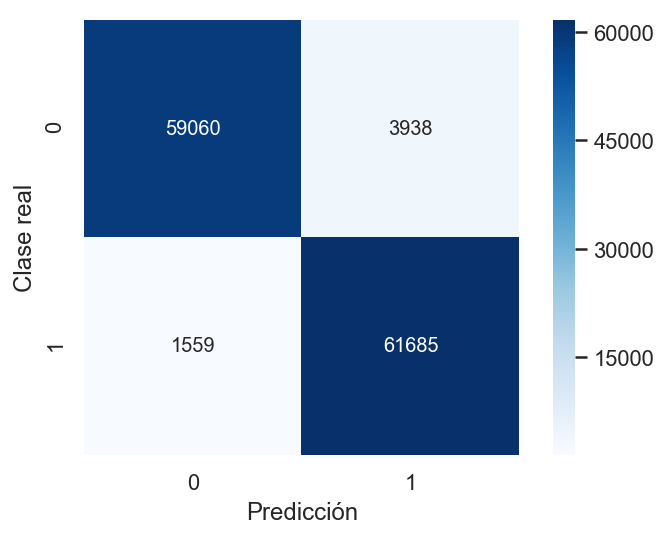

Resultados
Accuracy: 0.956
              precision    recall  f1-score   support

           0       0.97      0.94      0.96     62998
           1       0.94      0.98      0.96     63244

    accuracy                           0.96    126242
   macro avg       0.96      0.96      0.96    126242
weighted avg       0.96      0.96      0.96    126242



In [13]:
y_pred_train = minsait_pipe_rfc_p.predict(X_train)
#y_prob = minsait_pipe_rfc_p.predict_proba(X_test)[:,1]
show_results(y_train, y_pred_train)
print(classification_report(y_train, y_pred_train))

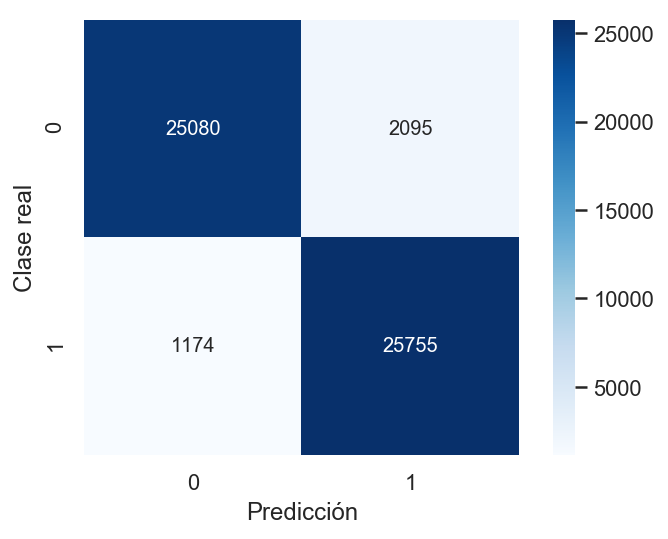

Resultados
Accuracy: 0.94
              precision    recall  f1-score   support

           0       0.96      0.92      0.94     27175
           1       0.92      0.96      0.94     26929

    accuracy                           0.94     54104
   macro avg       0.94      0.94      0.94     54104
weighted avg       0.94      0.94      0.94     54104



In [14]:
y_pred = minsait_pipe_rfc_p.predict(X_test)
#y_prob = minsait_pipe_rfc_p.predict_proba(X_test)[:,1]
show_results(y_test, y_pred)
print(classification_report(y_test, y_pred))

In [60]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def show_results_p(y, y_pred):
    print("Resultados: ")
    print('Accuracy: {}'.format(round(accuracy_score(y, y_pred), 3)))
    print('Recall: {}'.format(round(recall_score(y, y_pred), 3)))
    print('Precision: {}'.format(round(precision_score(y, y_pred), 3)))
    print('f1 score: {}'.format(round(f1_score(y, y_pred), 3)))

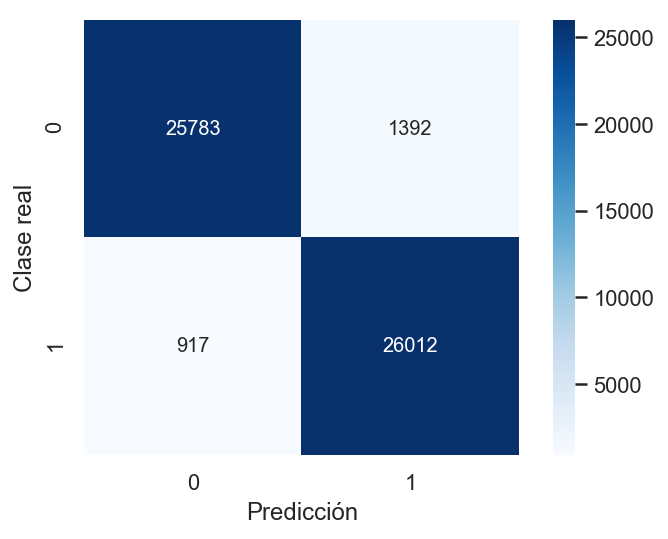

Resultados
Accuracy: 0.957
Resultados: 
Accuracy: 0.957
Recall: 0.966
Precision: 0.949
f1 score: 0.958


In [76]:
y_prob_reg = y_prob >= 0.5

show_results(y_test, y_prob_reg)
show_results_p(y_test, y_prob_reg)

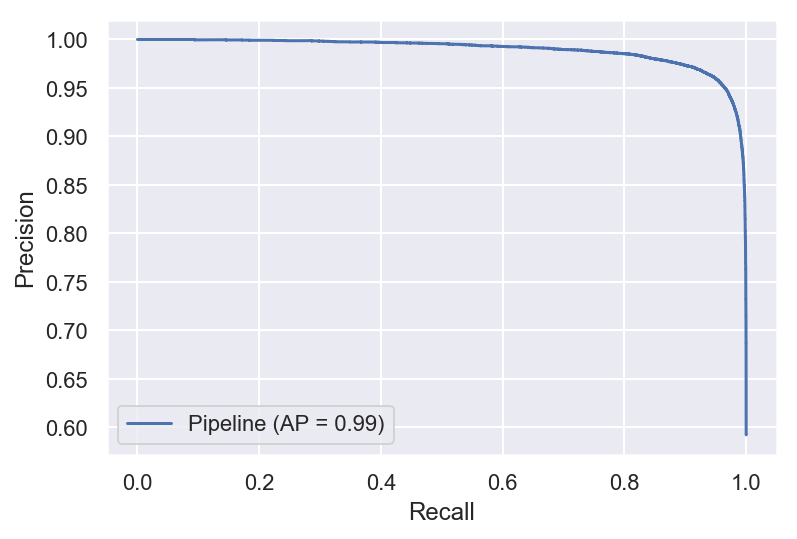

In [75]:
from sklearn.metrics import plot_precision_recall_curve
plot_precision_recall_curve(minsait_pipe_rfc_p, X_test, y_test);

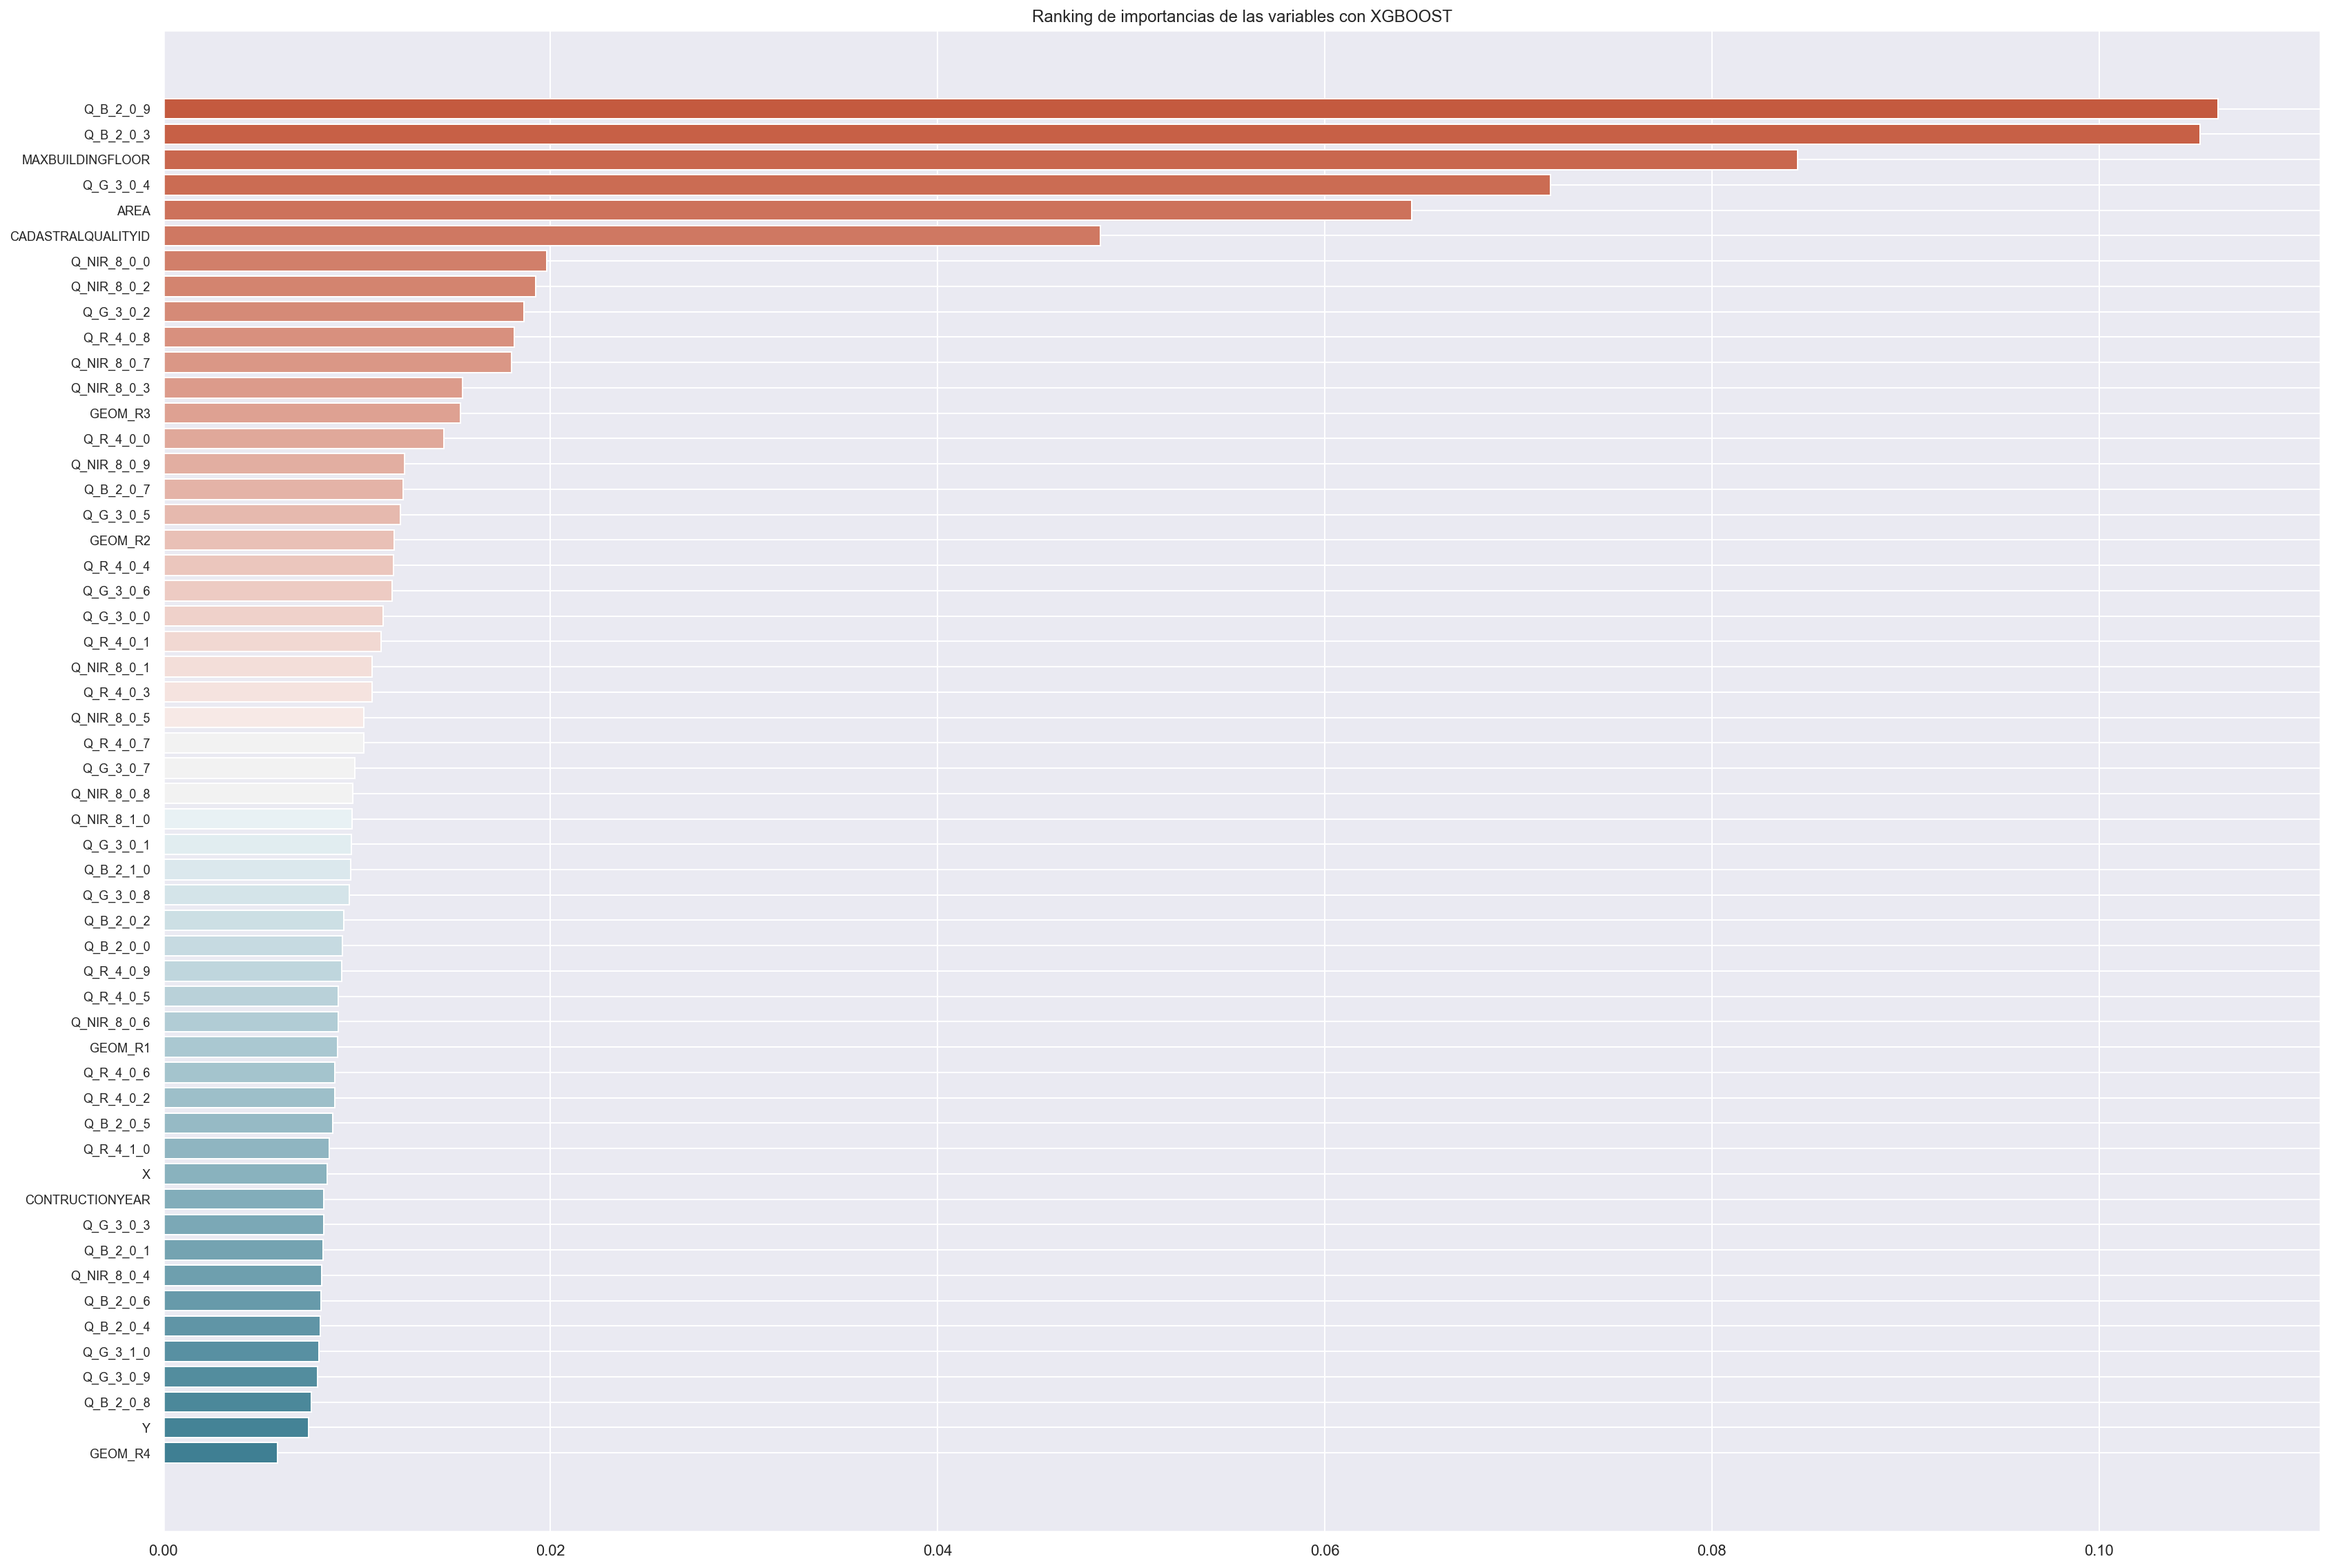

In [55]:
# Extrae las importancias
importances = minsait_pipe_rfc_p['clas'].feature_importances_
# Extrae los índices ordenados de menor a mayor
ranking = np.argsort(importances)

#Ahora que hemos obtenido las importancias de las variables y su ranking, vamos a dibujarlo
plt.figure(figsize=(28,20))
plt.title("Ranking de importancias de las variables con XGBOOST")
plt.barh(range(df.shape[1]-2), importances[ranking],color=sns.diverging_palette(220, 20, n=55),align='center')
plt.yticks(range(df.shape[1]-2), X.columns[ranking], fontsize=9)
plt.show()

In [53]:
model_multi = pickle.load(open('./models/multiclass_14_03.pkl', 'rb'))

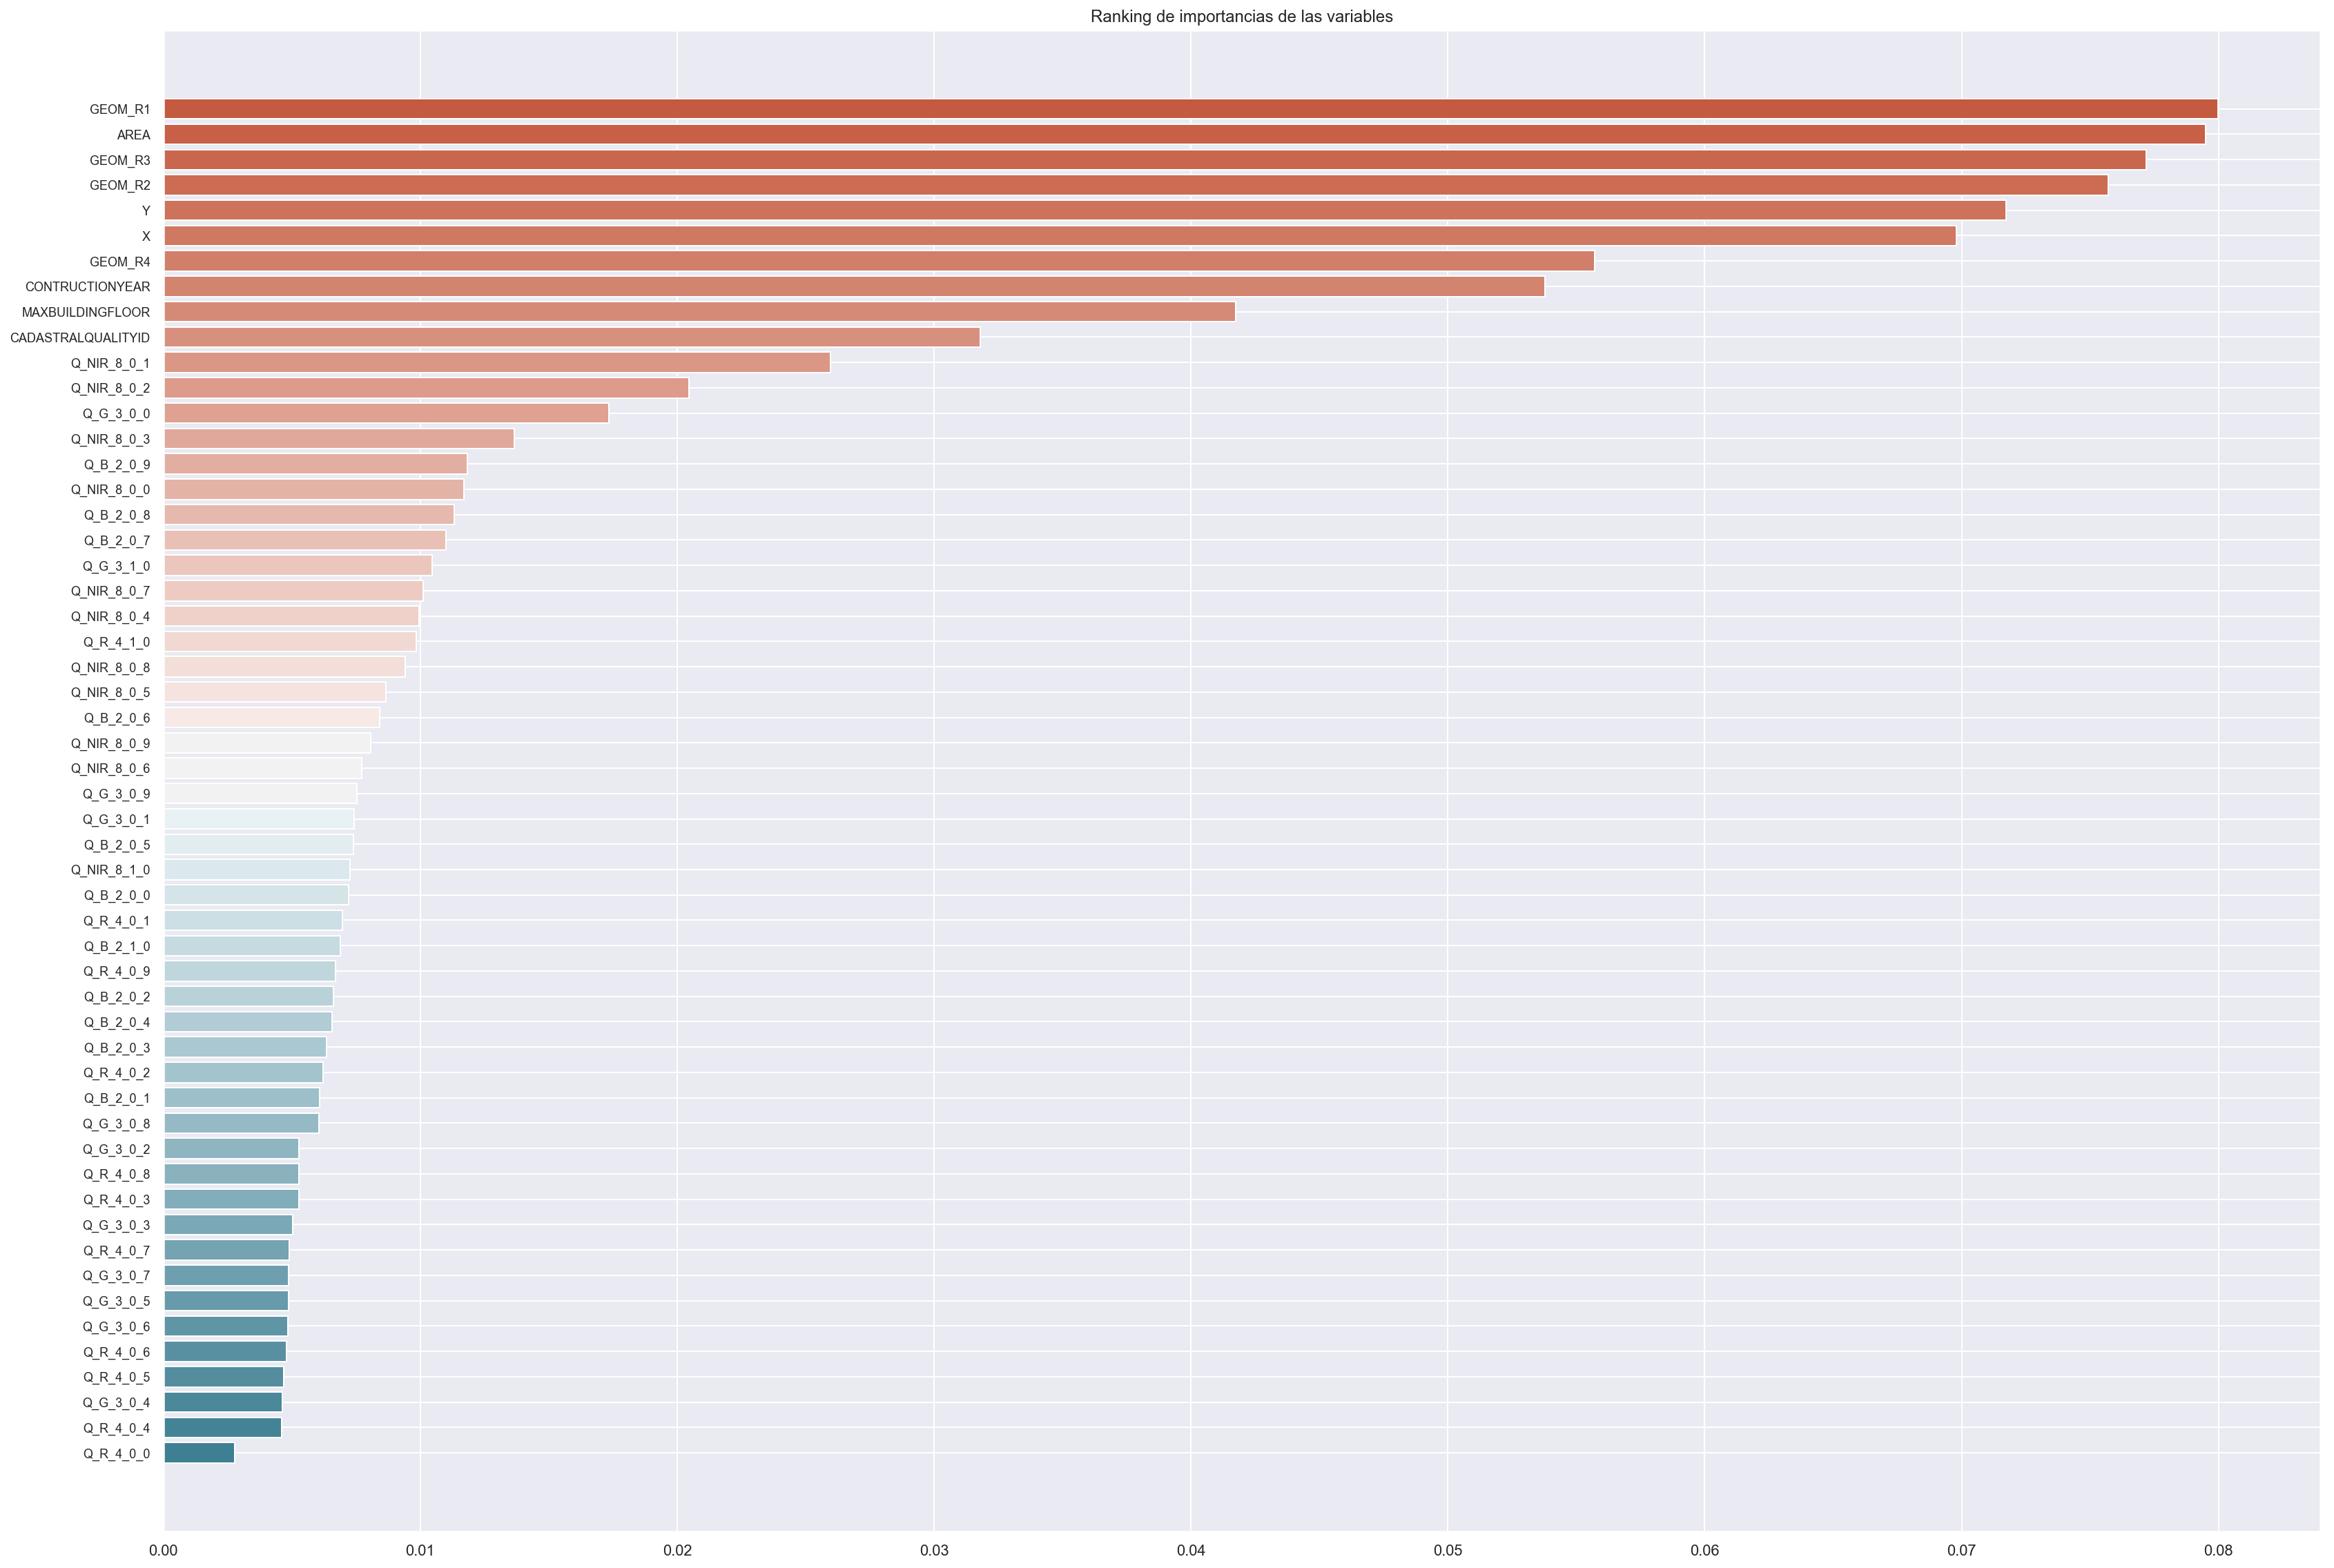

In [56]:
# Extrae las importancias
importances = model_multi['clas'].feature_importances_
# Extrae los índices ordenados de menor a mayor
ranking = np.argsort(importances)

#Ahora que hemos obtenido las importancias de las variables y su ranking, vamos a dibujarlo
plt.figure(figsize=(28,20))
plt.title("Ranking de importancias de las variables")
plt.barh(range(df.shape[1]-2), importances[ranking],color=sns.diverging_palette(220, 20, n=55),align='center')
plt.yticks(range(df.shape[1]-2), X.columns[ranking], fontsize=9)
plt.show()

In [75]:
import pickle
pickle.dump(minsait_pipe_rfc_p, open('./models/binary_smote_15_03_xgboost_10_100.pkl', 'wb'))

---

# Modelo multietiqueta con smote

In [11]:
X = df.drop(columns=df.columns[-2:]).copy()
y = df['CLASE'].copy()

#Obtenemos las columnas nunéricas
number_df_columns = df.select_dtypes(include=np.number).columns.tolist()
number_df_columns.remove('SUBCLASE')

#Transformación que se le va a aplicar a las columnas numéricas
num_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
                             ('scaler', StandardScaler())])
#Transformador que se aplica a cada una de las columnas en función a lo declarado previamente
df_minsait_trans = ColumnTransformer(transformers=[('num', num_transformer, number_df_columns)])
sm = SMOTE(random_state=10, sampling_strategy='not majority')
X_res_mult, y_res_mult = sm.fit_resample(X, y)

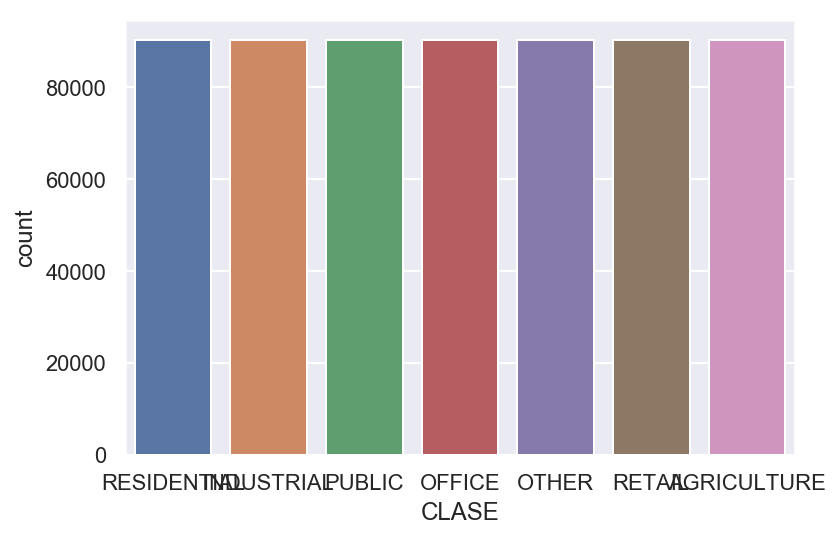

In [17]:
sns.countplot(y_res_mult);

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_res_mult, y_res_mult, test_size=0.3, random_state=10)

In [21]:
rfc_p_multi_model = RandomForestClassifier(random_state=10)

parameters = {}
parameters['clas__max_depth'] = [10] #Quitamos None para que no sobreajuste al conjunto de train y que no pueda hacer la profundidad que el modelo desee. 
                                               # Lo forzamos a ponerle profundidad, como máximo 30, aunque se podría establecer mayor profundidad pero he decidido que sea esa.
parameters['clas__n_estimators'] = [200]
parameters['clas__criterion'] = ['gini']
parameters['clas__class_weight'] = ['balanced']

minsait_pipe_rfc_multi_p = Pipeline(steps=[('prep', df_minsait_trans), ('clas', rfc_p_multi_model)])

GSR_p = GridSearchCV(minsait_pipe_rfc_multi_p, parameters, cv=5, n_jobs=-1, scoring='accuracy', refit=True, verbose=1)
GSR_p.fit(X_train, y_train)
    
print("Mejor score: ", GSR_p.best_score_)
print("Mejore configuración de parámetros: ", GSR_p.best_params_)

minsait_pipe_rfc_multi_p = GSR_p.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.2min finished


Mejor score:  0.65367424559859
Mejore configuración de parámetros:  {'clas__class_weight': 'balanced', 'clas__criterion': 'gini', 'clas__max_depth': 10, 'clas__n_estimators': 200}


In [23]:
y_pred = minsait_pipe_rfc_multi_p.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

 AGRICULTURE       0.95      0.99      0.97     27085
  INDUSTRIAL       0.69      0.60      0.64     26982
      OFFICE       0.59      0.57      0.58     27268
       OTHER       0.66      0.77      0.71     26976
      PUBLIC       0.52      0.48      0.50     26997
 RESIDENTIAL       0.60      0.77      0.68     27195
      RETAIL       0.55      0.41      0.47     26861

    accuracy                           0.66    189364
   macro avg       0.65      0.66      0.65    189364
weighted avg       0.65      0.66      0.65    189364



In [24]:
import pickle
pickle.dump(minsait_pipe_rfc_multi_p, open('./models/multiclass_smote_18_03.pkl', 'wb'))